Importations

In [1]:
import numpy as np
import scipy
from scipy import signal
from sklearn.decomposition import PCA
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from cycler import cycler

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import importlib

In [2]:
np.random.seed(0)
colors = ('indianred','darkorange','gold','lime','turquoise','royalblue','blueviolet','magenta')
%matplotlib notebook

In [3]:
from fcts_aff_anal import *

Importations des données

In [4]:
data_file = pd.HDFStore('/opt/DATA/train_test_arrays.h5').root.test_array.read()
x_test_array = data_file['x']
y_test_array = data_file['y']
test_array = pd.DataFrame({'x': x_test_array.tolist(), 'y': y_test_array.tolist()})

In [5]:
random_seed = 7
time_delay = 8
nb_neurones = 100

data_file = pd.HDFStore('/opt/DATA/RNN.h5')
group = data_file.get_node('RNN_seed_'+str(random_seed)+'_delay_'+str(time_delay))

table = group.loss.read()
loss = table['loss']
table = group.training_steps.read()
w_train_array = table['w']
wout_train_array = table['wout']

table = group.testing_results.read()
states = table['states']
output = table['output']
test = pd.DataFrame({'states':states.tolist(), 'output':output.tolist()})

table = group.final_weights.read()
win = table['win'][0]
w = table['w'][0]
wout = table['wout'][0]
    
data_file.close()

In [6]:
#np.savetxt('s7d8_output.gz',output[:50000],comments='Output during testing for random_seed = 7 and time_delay = 8')
#np.savetxt('s7d8_states.gz',states[:50000],comments='States of neurons during testing for random_seed = 7 and time_delay = 8')

In [7]:
data_file = pd.HDFStore('/opt/DATA/analyse.h5')
data = data_file.root.data.read()
data_file.close()

min_q = data[np.where(np.all((data['random_seed']==random_seed,data['time_delay']==time_delay),axis=0))[0]]['min_q'][0]
q_type = data[np.where(np.all((data['random_seed']==random_seed,data['time_delay']==time_delay),axis=0))[0]]['q_type'][0]
q_type = q_type[np.where(np.any(min_q!=0,axis=1))[0]]
min_q = min_q[np.where(np.any(min_q!=0,axis=1))[0]]

Analyse

In [8]:
pca = PCA(n_components=3)
pca.fit(states)
pc_1, pc_2, pc_3 = pca.transform(states).T

out_type = np.array([np.argmax(tension_to_index(out)) for out in test['output']])
test['out_type'] = out_type

In [9]:
center_array = []
stand_dev_array = []
for i in range(8):
    indexes = np.where(np.equal(out_type,i*np.ones(len(out_type))))[0]
    center, stand_dev = centerStandDev(states[indexes])
    center_array.append(center)
    stand_dev_array.append(stand_dev)
center_array = np.array(center_array)
stand_dev_array = np.array(stand_dev_array)

In [10]:
vec = []
vec.append(center_array[np.argmax(tension_to_index((1,1,1)))]-center_array[np.argmax(tension_to_index((-1,1,1)))])
vec.append(center_array[np.argmax(tension_to_index((1,1,1)))]-center_array[np.argmax(tension_to_index((1,-1,1)))])
vec.append(center_array[np.argmax(tension_to_index((1,1,1)))]-center_array[np.argmax(tension_to_index((1,1,-1)))])
vec = np.array(vec)
#vec = vec/np.linalg.norm(vec,axis=1)[:,None]

In [11]:
pca_all = PCA()
pca_all.fit(states)
cov_eigvals = pca_all.explained_variance_

np.sum(cov_eigvals)**2/np.sum(cov_eigvals**2)

5.16990806493815

Dessin de l'analyse

<IPython.core.display.Javascript object>


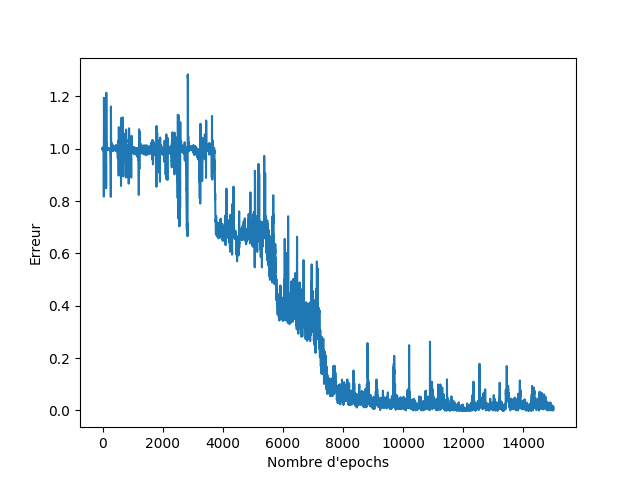

In [12]:
plotTrainResults(loss)

In [13]:
min_q_pca = pca.transform(min_q).T
interact(plotPrincipalComponents, dots=False, lines=True, spheres=False, slowpts=True, vecs=True, nb=fixed(3000), pc_1=fixed(pc_1), pc_2=fixed(pc_2), pc_3=fixed(pc_3), out_type=fixed(out_type), min_q=fixed(min_q_pca), q_type=fixed(q_type), vecs_array=fixed(pca.transform(vec)), center_array=fixed(pca.transform(center_array)), stand_dev_array=fixed(pca.transform(stand_dev_array)))

interactive(children=(Checkbox(value=False, description='dots'), Checkbox(value=True, description='lines'), Ch…

<function fcts_aff_anal.plotPrincipalComponents(dots, lines, spheres, slowpts, vecs, nb, pc_1, pc_2, pc_3, out_type, min_q=[], q_type=[], vecs_array=[], center_array=[], stand_dev_array=[])>

In [14]:
nb_before = time_delay+10
nb_after = 11
pattern = np.concatenate((np.ones(nb_before)*7,np.ones(nb_after)*3)).astype('int')
triggered_indexes = matchPattern(out_type,pattern)
triggered_indexes = np.array([np.arange(i,i+nb_before+nb_after) for i in triggered_indexes])
triggered_states = np.mean(states[triggered_indexes],axis=0)

triggered_pca = PCA(3)
triggered_pca.fit(triggered_states)
triggered_pc_1, triggered_pc_2, triggered_pc_3 = triggered_pca.transform(triggered_states).T

<IPython.core.display.Javascript object>


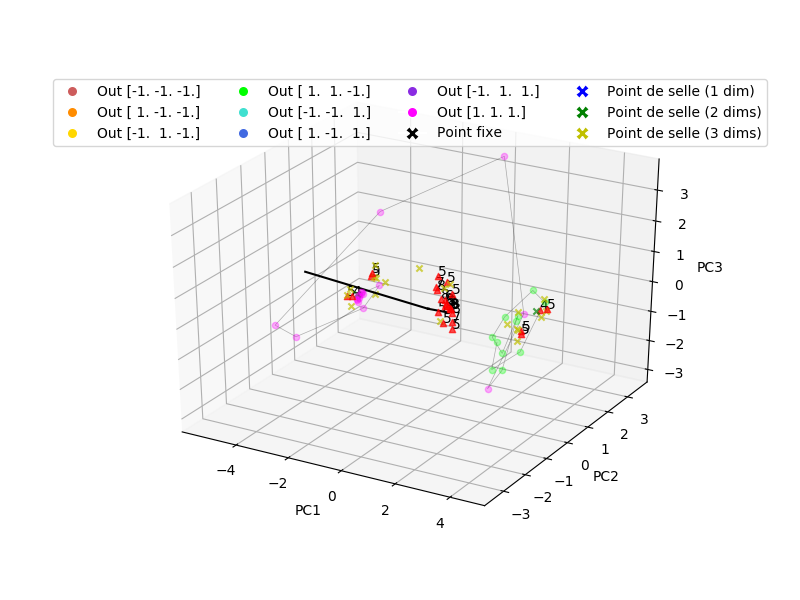

In [15]:
plotPrincipalComponents(True,True,False,True,True,nb_before+nb_after, triggered_pc_1, triggered_pc_2, triggered_pc_3, pattern, triggered_pca.transform(min_q).T, q_type, triggered_pca.transform(vec))

<IPython.core.display.Javascript object>


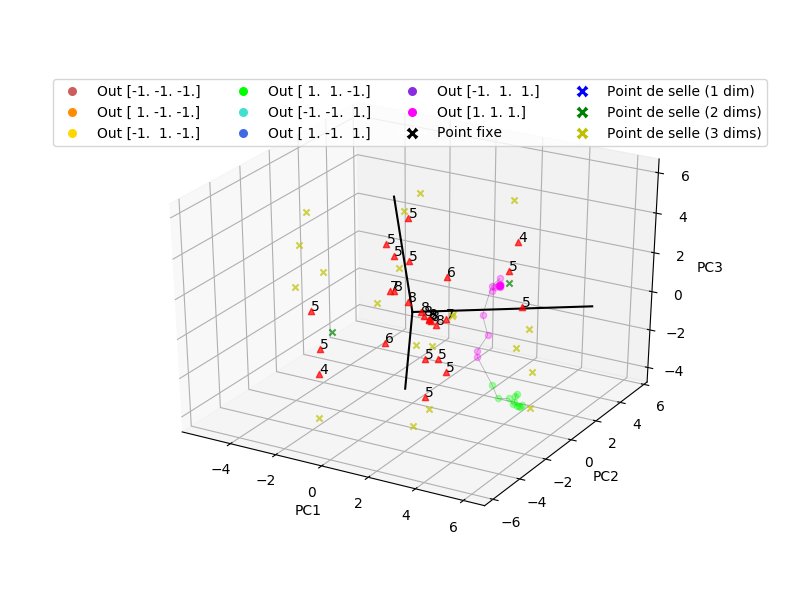

In [16]:
triggered_pc_1_2, triggered_pc_2_2, triggered_pc_3_2 = pca.transform(triggered_states).T
plotPrincipalComponents(True,True,False,True,True,nb_before+nb_after, triggered_pc_1_2, triggered_pc_2_2, triggered_pc_3_2, pattern, pca.transform(min_q).T, q_type, pca.transform(vec))

<IPython.core.display.Javascript object>


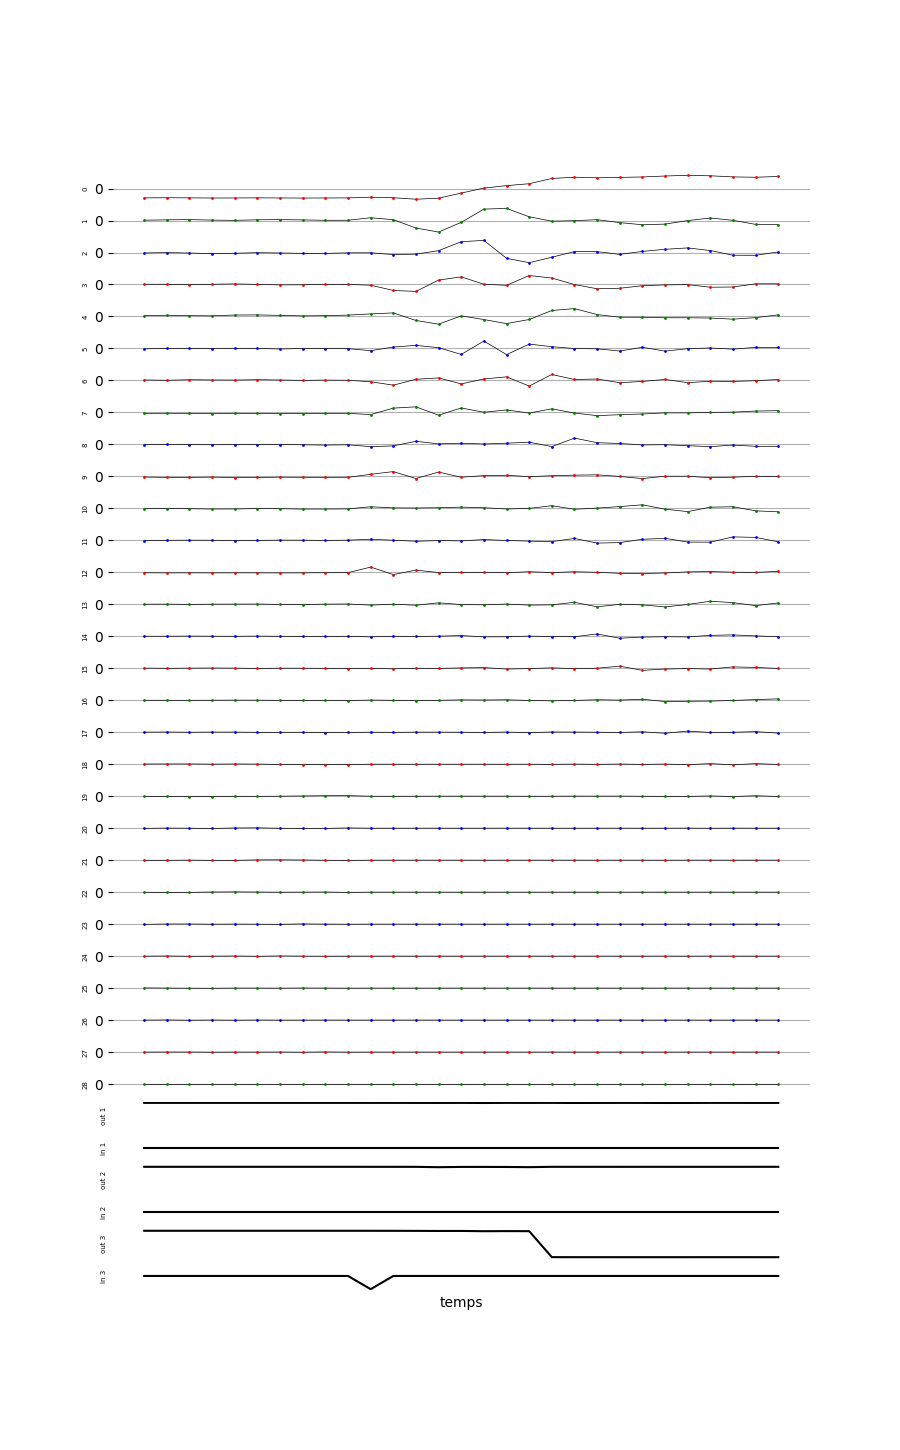

In [17]:
triggered_pca_all = PCA()
triggered_pca_all.fit(triggered_states)

output_array = np.tanh(np.matmul(triggered_states,wout))
input_array = np.zeros(output_array.shape)
input_array[nb_before-time_delay] = (index_to_tension(pattern[-1])-index_to_tension(pattern[0]))/2
plotNeuronsActivity(triggered_pca_all.transform(triggered_states).T,input_array,output_array)

Comparaison avec transformation de fourier

<IPython.core.display.Javascript object>


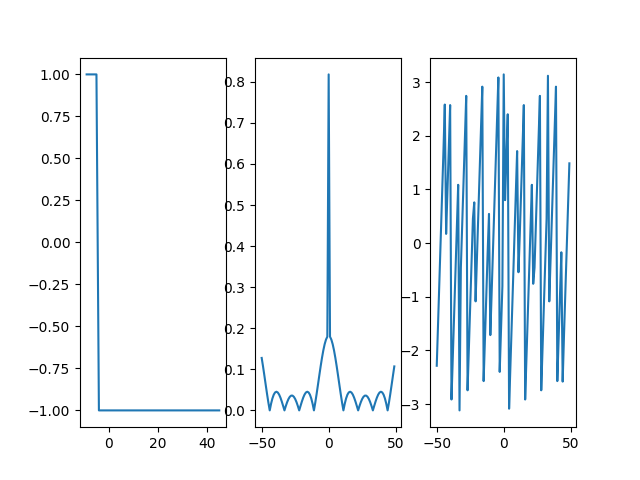

In [18]:
T = 55
t = np.arange(-9,46)
y = np.concatenate((np.ones(5),-1*np.ones(50)))

n = np.arange(-50,50)
cn = np.array([np.sum(y*np.exp(-2j*np.pi*n_i/T*t))/T for n_i in n])

fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.plot(t,y)
ax2.plot(n,np.abs(cn))
ax3.plot(n,np.angle(cn))

<IPython.core.display.Javascript object>


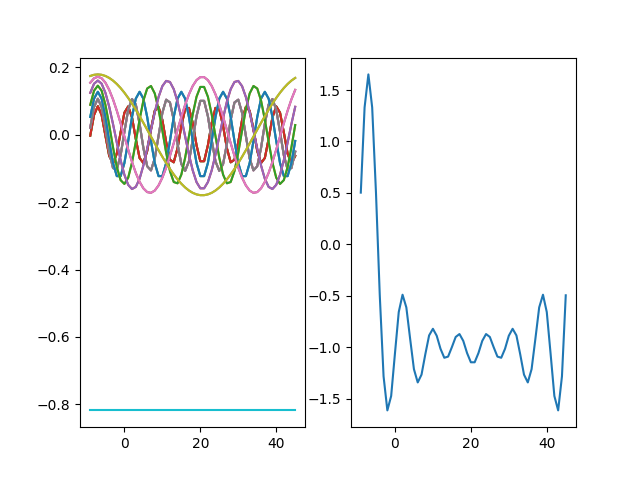

In [19]:
princ_comps = np.argsort(np.abs(cn))[-20:]
fd = np.array([cn[i]*np.exp(2j*np.pi*n[i]/T*t) for i in princ_comps]).real

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(t,fd.T)
ax2.plot(t,np.sum(fd, axis=0))

<IPython.core.display.Javascript object>


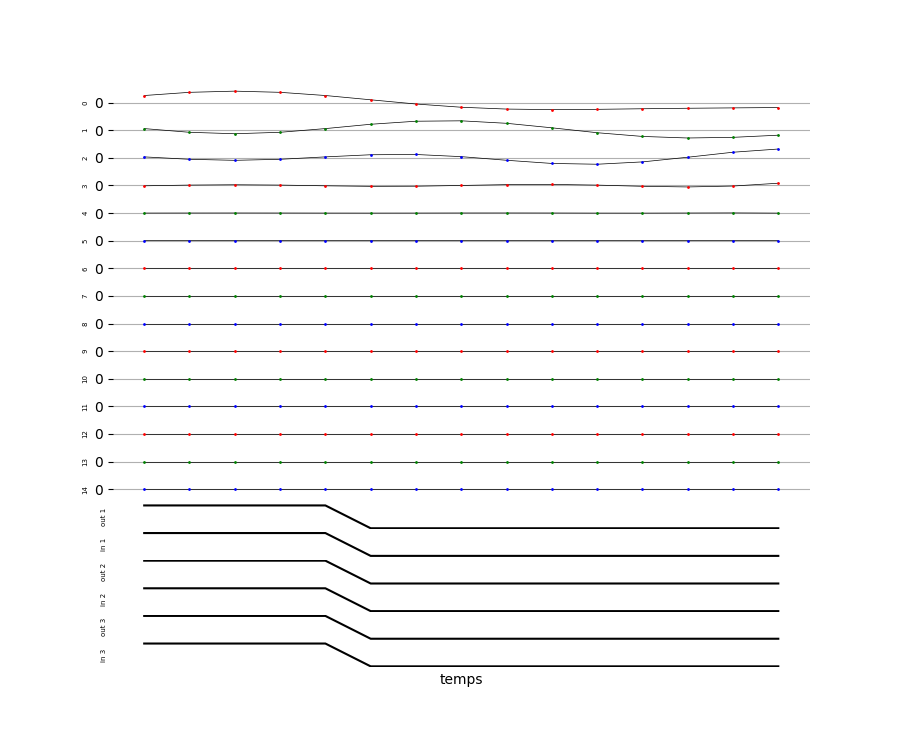

In [20]:
fd = fd.T

pca_fourier = PCA()
pca_fourier.fit(fd[:15])
plotNeuronsActivity(pca_fourier.transform(fd[:15]).T,np.array([y,y,y]).T[:15],np.array([y,y,y]).T[:15])